# Data Visualization

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from dask.distributed import Client

client = Client(
    threads_per_worker=4
)
client

2022-06-30 02:35:35,204 - distributed.diskutils - INFO - Found stale lock file and directory '/home/rui/BDDC-2/proj2/dask-worker-space/worker-n8twtlww', purging
2022-06-30 02:35:35,204 - distributed.diskutils - INFO - Found stale lock file and directory '/home/rui/BDDC-2/proj2/dask-worker-space/worker-xx072470', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 8,Total memory: 15.05 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43071,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.05 GiB
Comm: tcp://127.0.0.1:42625,Total threads: 4
Dashboard: http://127.0.0.1:38529/status,Memory: 7.53 GiB
Nanny: tcp://127.0.0.1:35673,


In [3]:
import dask.dataframe as dd
import os

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt

## ICU Stays Table

In [5]:
local = True

if local:
    filename = os.path.join('data', 'ICUSTAYS-short.csv')
else:
    filename = 'gs://bigdata2-util/ICUSTAYS.csv'

icu_stays_df = dd.read_csv(filename, parse_dates=['INTIME', 'OUTTIME'])

In [6]:
icu_stays_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [7]:
icu_stays_df.describe().compute()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,FIRST_WARDID,LAST_WARDID,LOS
count,61532.000000,61532.000000,61532.000000,61532.000000,61532.000000,61532.000000,61522.000000
mean,30766.500000,33888.605912,149954.470649,249962.710248,33.085663,32.978206,4.917972
std,17762.902719,28127.690913,28898.895904,28890.574867,19.102204,19.028609,9.638784
min,1.000000,2.000000,100001.000000,200001.000000,7.000000,7.000000,0.000100
25%,15383.750000,12047.500000,124933.750000,224935.500000,14.000000,14.000000,1.108025
50%,30766.500000,24280.500000,149911.500000,249940.000000,33.000000,33.000000,2.092250
75%,46149.250000,54191.500000,174997.250000,274972.500000,52.000000,52.000000,4.483175
max,61532.000000,99999.000000,199999.000000,299999.000000,57.000000,57.000000,173.072500


## Events Table

In [8]:
local = True

if local:
    filename = os.path.join('data', 'EVENTS-short.csv')
else:
    filename = 'gs://bigdata2-util/EVENTS.csv'

events_df = dd.read_csv(filename, parse_dates=['CHARTTIME', 'STORETIME'], dtype={
    'CGID': 'Int64', 'ICUSTAY_ID': 'Int64'
})

In [9]:
events_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,788,36,165660,241249,223834,2134-05-12 12:00:00,2134-05-12 13:56:00,17525,15.00,15.00,L/min,0,0,NaN,NaN
1,789,36,165660,241249,223835,2134-05-12 12:00:00,2134-05-12 13:56:00,17525,100.00,100.00,NaN,0,0,NaN,NaN
2,790,36,165660,241249,224328,2134-05-12 12:00:00,2134-05-12 12:18:00,20823,0.37,0.37,NaN,0,0,NaN,NaN
3,791,36,165660,241249,224329,2134-05-12 12:00:00,2134-05-12 12:19:00,20823,6.00,6.00,min,0,0,NaN,NaN
4,792,36,165660,241249,224330,2134-05-12 12:00:00,2134-05-12 12:19:00,20823,2.50,2.50,NaN,0,0,NaN,NaN


### Item values over time for a given ICU STAY

In [10]:
def plot_icu_histogram(icu_id, dataframe=events_df):
    data = dataframe[['SUBJECT_ID', 'VALUENUM', 'ICUSTAY_ID', 'CHARTTIME', 'ITEMID']] \
        .query('ICUSTAY_ID == {}'.format(icu_id)) \
        .compute()

    plot = sns.relplot(x='CHARTTIME', y='VALUENUM', col='ICUSTAY_ID',
                       kind='scatter',
                       aspect=3,
                       data=data) \
        .set(title='Item values over time for ICUSTAY_ID {}'.format(icu_id))

    ax = plt.gca()
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    plt.xticks(rotation=30)

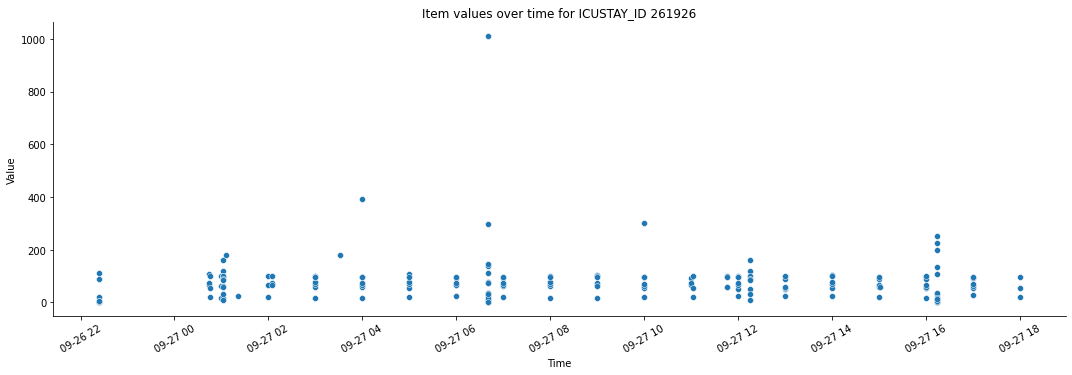

In [11]:
plot_icu_histogram(icu_id=261926)

### Values of an item over time

In [12]:
def item_plot(item_id, dataframe=events_df):
    dataframe[['ITEMID', 'CHARTTIME', 'VALUENUM']] \
        .query('ITEMID == {}'.format(item_id)) \
        .compute() \
        .plot(x='CHARTTIME', y='VALUENUM',
              style='.',
              figsize=(16, 7),
              title='Values for ITEMID {}'.format(item_id))

    ax = plt.gca()
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    plt.xticks(rotation=20)

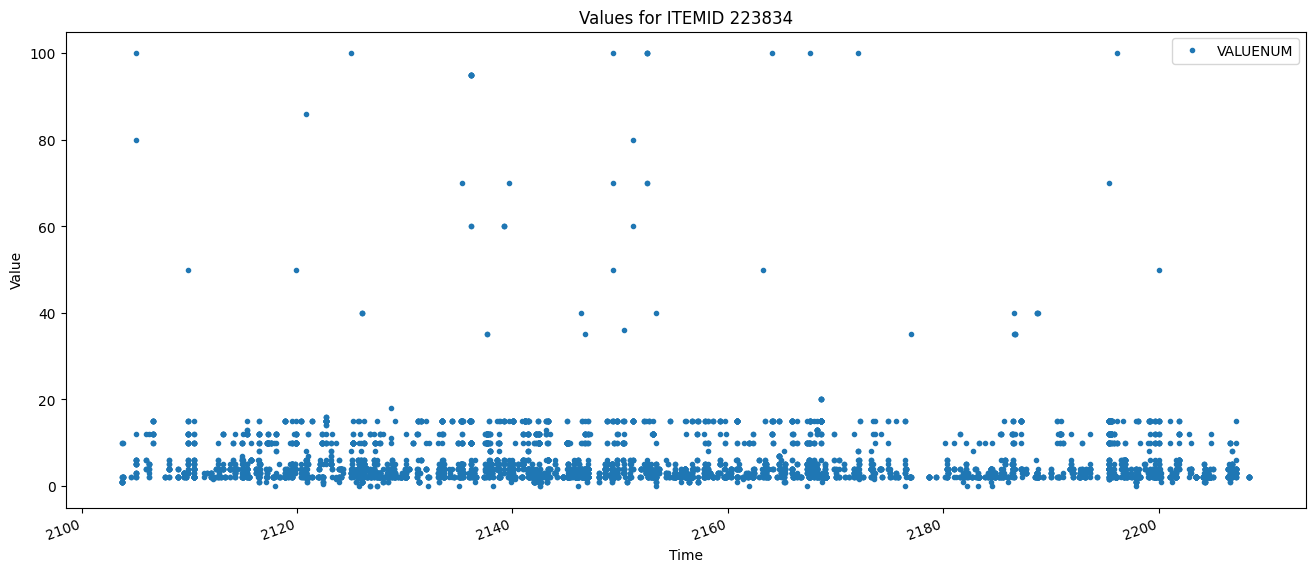

In [13]:
item_plot(item_id=223834)

### Items and their values values for a given subject

In [14]:
def subject_values_plot(subject_id, dataframe=events_df):
      dataframe[['SUBJECT_ID', 'ITEMID', 'VALUENUM', 'HADM_ID']]\
                .query('SUBJECT_ID == {}'.format(subject_id))\
                .compute()\
                .groupby('HADM_ID')['ITEMID', 'VALUENUM']\
                .plot(x='ITEMID', y='VALUENUM', kind='scatter',
                      title='Values for the subject {}'.format(subject_id))

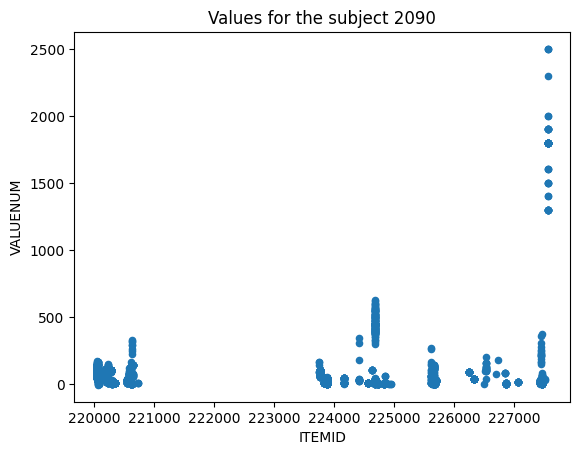

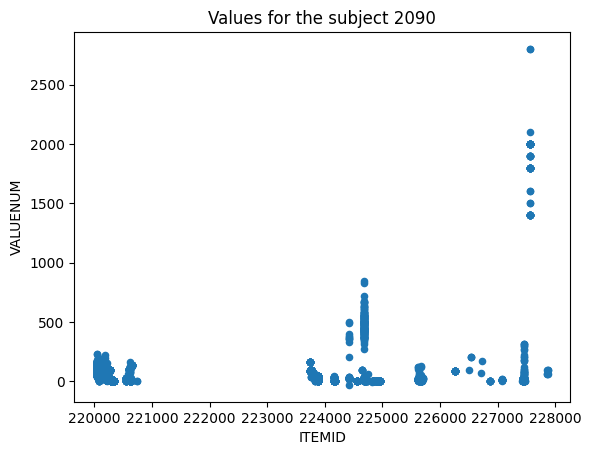

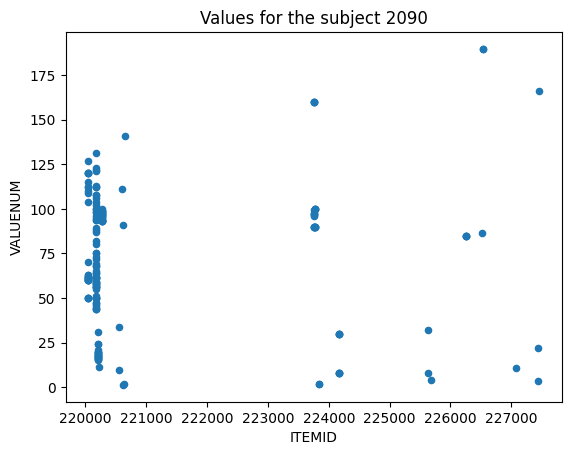

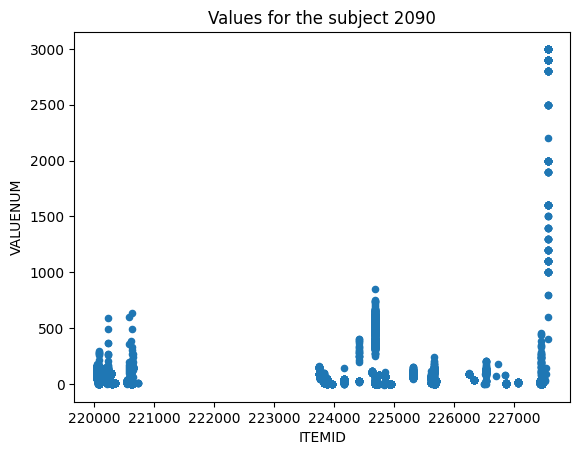

In [15]:
subject_values_plot(subject_id=2090)

### Frequency (Count) of each item

In [16]:
def items_frequency(dataframe=events_df):
    dataframe[['ITEMID', 'VALUENUM']].compute() \
        .groupby('ITEMID') \
        .count() \
        .hist()

    plt.title('Frequency of each item')

    ax = plt.gca()
    ax.set_xlabel('Item ID')
    ax.set_ylabel('Frequency')
    plt.xticks(rotation=20)

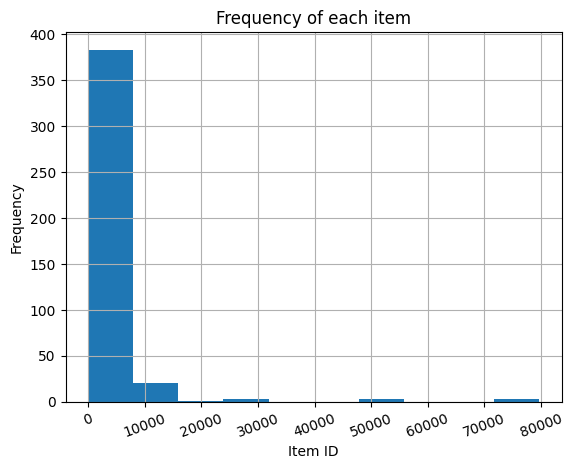

In [17]:
items_frequency()

## Number of events for each hospital admission

In [18]:
def events_by_hadm(dataframe=events_df):
    events_count_df = dataframe.groupby('HADM_ID')['ROW_ID']\
        .count()\
        .compute()\
        .to_frame()\
        .reset_index()

    events_count_df.rename(columns={'ROW_ID': '# of Events'}, inplace=True)
    
    return events_count_df

In [19]:
events_by_hadm()

,HADM_ID,# of Events
0,100009,846
1,100020,257
2,100068,1611
3,100182,373
4,100336,1228
...,...,...
880,199413,42
881,199574,3401
882,199603,156
883,199609,571


In [20]:
events_by_hadm().describe()

,HADM_ID,# of Events
count,885.000000,885.000000
mean,149205.962712,1129.942373
std,28701.923473,4978.005378
min,100009.000000,14.000000
25%,124661.000000,220.000000
50%,148585.000000,453.000000
75%,173581.000000,971.000000
max,199622.000000,139383.000000


### Number of caregivers for a given hospital admission

In [21]:
def cg_hadm(hadm_id, dataframe=events_df):
    return dataframe.compute()[['HADM_ID', 'CGID']]\
                    .query('HADM_ID == {}'.format(hadm_id))\
                    .drop_duplicates()['CGID'].to_list()

In [22]:
cg_ids = cg_hadm(hadm_id=165660)

print('Number of CG related to HADM_ID 165660: {}'.format(len(cg_ids)), end='\n\n')

for x in cg_ids:
    print(x)

Number of CG related to HADM_ID 165660: 21

17525
20823
20889
18428
16934
20290
15225
16797
20111
15526
17698
15815
14419
17738
15065
21367
17457
21198
16042
16223
14792


### Hospital admissions related to a caregiver

In [23]:
def hadm_cg(cgid, dataframe=events_df):
    return dataframe.compute()[['CGID', 'HADM_ID']]\
                    .query('CGID == {}'.format(cgid))\
                    .drop_duplicates()['HADM_ID'].to_list()

In [24]:
admissions = hadm_cg(cgid=17525)

print('Number of hospital admissions related to CGID 17525: {}'.format(len(admissions)), end='\n\n')

for x in admissions:
    print(x)

Number of hospital admissions related to CGID 17525: 33

165660
182383
147469
158767
125857
170024
102486
107939
195990
171462
192399
158507
197882
147237
197750
119255
148207
125124
198630
117599
106374
128932
162930
175644
163199
108877
181224
191454
145304
121938
163365
134638
155230
